<a href="https://colab.research.google.com/github/manuel-suarez/denoising-tests/blob/main/SAR_Image_Despeckling_Using_a_Convolutional_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [SAR Image Despeckling Using a Convolutional Neural](https://github.com/TheKiteFlier/SAR-Image-Despeckling-Using-CNN-/blob/main/SAR%20Image%20Despeckling%20Using%20a%20Convolutional.ipynb)

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,ReLU,BatchNormalization,LeakyReLU
import os
from skimage.util import random_noise
import sys
import time
from tqdm.notebook import tqdm
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
# Extramos las imagenes de manera local en el entorno
from zipfile import ZipFile

gdrive_dir = '/content/gdrive'
with ZipFile(os.path.join(gdrive_dir,'MyDrive/DeepLearning/Sentinel 1&2','v_2.zip'), 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='kaggle/sentinel12/v_2')

In [18]:
INPUT_SIZE= (64,64)
BS=16
ROOT_DIR="kaggle/"

In [26]:
!rm kaggle/DATASET/DATA

In [27]:
!mkdir kaggle/DATASET/DATA

In [28]:
!mv kaggle/sentinel12/v_2/agri/s2/*.png kaggle/DATASET/DATA/

## Preparing data

In [19]:
DATASET=os.path.join(ROOT_DIR,'sentinel12/v_2')
DATA_GEN_INPUT=os.path.join(ROOT_DIR,'DATASET')

if os.path.exists(DATA_GEN_INPUT):
    shutil.rmtree(DATA_GEN_INPUT)
os.mkdir(DATA_GEN_INPUT)

src=os.path.join(DATASET,"agri/s2")
dst=os.path.join(DATA_GEN_INPUT,"DATA")
os.symlink(src,dst)

In [22]:
src

'kaggle/sentinel12/v_2/agri/s2'

In [20]:
def preprocessing_function(img):
    return np.float32(img/127.5-1)

In [29]:
generator=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function)
train_generator=generator.flow_from_directory(DATA_GEN_INPUT,
                                              target_size=INPUT_SIZE,
                                              class_mode=None,
                                              color_mode='grayscale',
                                              batch_size=BS,
                                              follow_links=True,)

Found 4000 images belonging to 1 classes.


In [31]:
img = next(train_generator)
print(img.shape)

(16, 64, 64, 1)


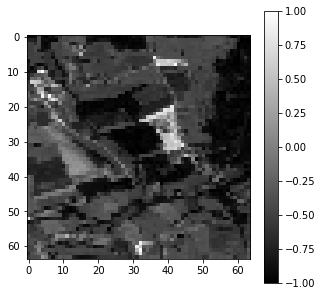

In [35]:
plt.figure(figsize=(5,5))
plt.imshow(img[0,:,:,0],cmap='gray')
plt.colorbar()

## Testing model

In [36]:
def test_model(data_generator):
    img1,img2=next(data_generator)[:2]
    noise_var=np.random.rand()*.25
    # noise_var=.3
    noisy_img1=random_noise(img1,mode='speckle',var=noise_var,clip=True)
    noisy_img2=random_noise(img2,mode='speckle',var=noise_var,clip=True)
    noisy_img1=np.expand_dims(noisy_img1,axis=[0,-1])
    noisy_img2=np.expand_dims(noisy_img2,axis=[0,-1])
    denoised_img1=model.predict(noisy_img1)
    denoised_img2=model.predict(noisy_img2)
    fig,ax=plt.subplots(3,2,figsize=(10,12))
    mapple=ax[0,0].imshow(img1)
    plt.colorbar(mapple,ax=ax[0,0])
    mapple=ax[0,1].imshow(img2)
    plt.colorbar(mapple,ax=ax[0,1])
    mapple=ax[1,0].imshow(noisy_img1[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[1,0])
    mapple=ax[1,1].imshow(noisy_img2[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[1,1])
    mapple=ax[2,0].imshow(denoised_img1[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[2,0])
    mapple=ax[2,1].imshow(denoised_img2[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[2,1])
    plt.show()

## Model definition

In [37]:
def create_model(input_shape=(256,256,1)):
    input_layer=Input(shape=input_shape)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same')(input_layer)
    x=LeakyReLU(.2)(x)
#   Here I'm using dialation in convolution layers but in the original paper There are NO dialation used
    for i in range(1,5):
        x=Conv2D(filters=64,kernel_size=(3,3),dilation_rate=i,padding='same',)(x)
        x=BatchNormalization()(x)
        x=LeakyReLU(.2)(x)
    for i in range(4,0,-1):
        x=Conv2D(filters=64,kernel_size=(3,3),dilation_rate=i,padding='same')(x)
        x=BatchNormalization()(x)
        x=ReLU()(x)
    x=Conv2D(filters=1,kernel_size=(3,3),padding='same')(x)
    x=ReLU()(x) 
    x= tf.keras.layers.Lambda(lambda x:x+tf.constant(1e-7))(x)
    x=tf.math.divide(input_layer,x)

    x=tf.math.tanh(x)